In [1]:
# importing required libraries
import pandas as pd  # pandas library
import numpy as np   # numphy library


In [2]:
#Reading Dataset
#df = pd.read_csv('../Data/raw/bank-full.csv', sep=',', encoding='latin1')
df = pd.read_excel('../Data/raw/bank-full.xlsx')  # reading the full dataset of bank
print(df.head())
print(df.shape)


   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  
(45211, 17)


**Step 1. Basic Foundational Cleaning: Pre-Split**

- Basic Cleaning the Lens through which you see the data.

    Logic: If data has duplicate rows or "month" written as "JAN" and "jan", these are structural errors. Fixing them across the whole dataset doesn't leak information; it just ensures the data is readable.

- Initial EDA (Univariate): Simply checking the "health" of the data (e.g., "Do I even have enough data to proceed?").

**Step 2. The Split (The Firewall)**

**Step 3. Statistical Modeling Cleaning: Post-Split**

Now in the Lab.

- Imputation/Scaling: You calculate the "Standard" (Mean/Mode) from the Train set. If the Test set has a missing value, you fill           it with the Train mode. This mimics the real world, where you use past knowledge to handle new, incomplete information.

- Handling Outliers

- Bivariate EDA & Heatmaps: By doing this only on the training set, you ensure that your decision to keep or drop a feature is based only on the data the model is allowed to learn from.

**Basic Cleaning: Do these BEFORE splitting:**

1. De-duplication: Removing exact duplicate rows.
2. Irrelevant Data: Dropping columns that have nothing to do with the target (e.g., Random IDs).
3. Formatting: Changing data types (e.g., converting a "Date" string to a DateTime object).

**Do these AFTER splitting:**

1. Handling Outliers: Defining what an outlier is based on the training distribution.
2. Imputation: Filling missing values using the mean, median, or mode of the training set only.
3. Scaling/Normalization: If you normalize based on the global maximum, you've leaked the range of the test set into your training process.
4. EDA: Visualizing correlations and distributions to decide which features to keep.


### Step 1. Basic Data Cleaning:

The initial step involves cleaning and preparing the raw data to remove inconsistencies, handle missing values, and make the dataset ready for analysis. 

1. Check for Missing Values: Ensure there are no null values.
2. Handle Duplicates: Identify and remove any duplicate rows.
3. Consistant Data for Analysis: Ensure consistent formats for categorical data (e.g., month values).
4. Standardize Strings: Strip spaces and lowercase all categories .

### Part B Data Cleaning only on train data after spliting data in to train and test.

1. Impute: Replace unknown in job or education with the mode.
2. Handle Outliers: Cap the extreme balance values (Capping/Winsorization).


In [3]:
# 1. Check for missing values in both datasets
missing = df.isnull().sum()
#missing_sub = df_sub.isnull().sum()

# 2. Identify duplicate rows: Check for duplicates in both datasets
duplicates = df.duplicated().sum()
#duplicates_sub = df_sub.duplicated().sum()

missing, duplicates #missing_sub, duplicates_sub

(age          0
 job          0
 marital      0
 education    0
 default      0
 balance      0
 housing      0
 loan         0
 contact      0
 day          0
 month        0
 duration     0
 campaign     0
 pdays        0
 previous     0
 poutcome     0
 y            0
 dtype: int64,
 np.int64(0))

String Standardizing First: One should lowercase and strip before calculate the Mode. If data have "Management" and "management", they are seen as different; standardizing them first gives a more accurate Mode for imputation.

In [6]:
# 3 & 4. Standardize Strings (Lowercase & Strip)
# This ensures 'Management' and 'management ' are treated as the same category

# convert data type first
df = df.convert_dtypes() 

# clean only string columns
cat_cols = df.select_dtypes(include=['string']).columns
df[cat_cols] = df[cat_cols].apply(lambda s: s.str.lower().str.strip())



print("Basic Cleaning done! \nData is standardized and missing and duplicats are identified. \nData are ready for initial EDA: Part A")

Basic Cleaning done! 
Data is standardized and missing and duplicats are identified. 
Data are ready for initial EDA: Part A


Looks like there are no missing values in our data. However, if we look at the categorical data there are 'unknown' values which we can consider as 'missing' data.

Also, there are no duplicates rows in our data. 

The data are consistant and standardize for Initial Exploration.

### Initial EDA : Univariate 

1. Identify the "Problem" Areas
    Before cleaning, we use Univariate EDA to find the things that need fixing.

2. Numerical Outliers: Use boxplots to see if the €102k balance is an error or just a wealthy customer.

3. Categorical "Unknowns": Use count plots to see that poutcome is mostly "unknown." This justifies why we might drop it later or treat "unknown" as a category.

In [7]:
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import xlabel, ylabel

plt.xlabel = xlabel
plt.ylabel = ylabel
 

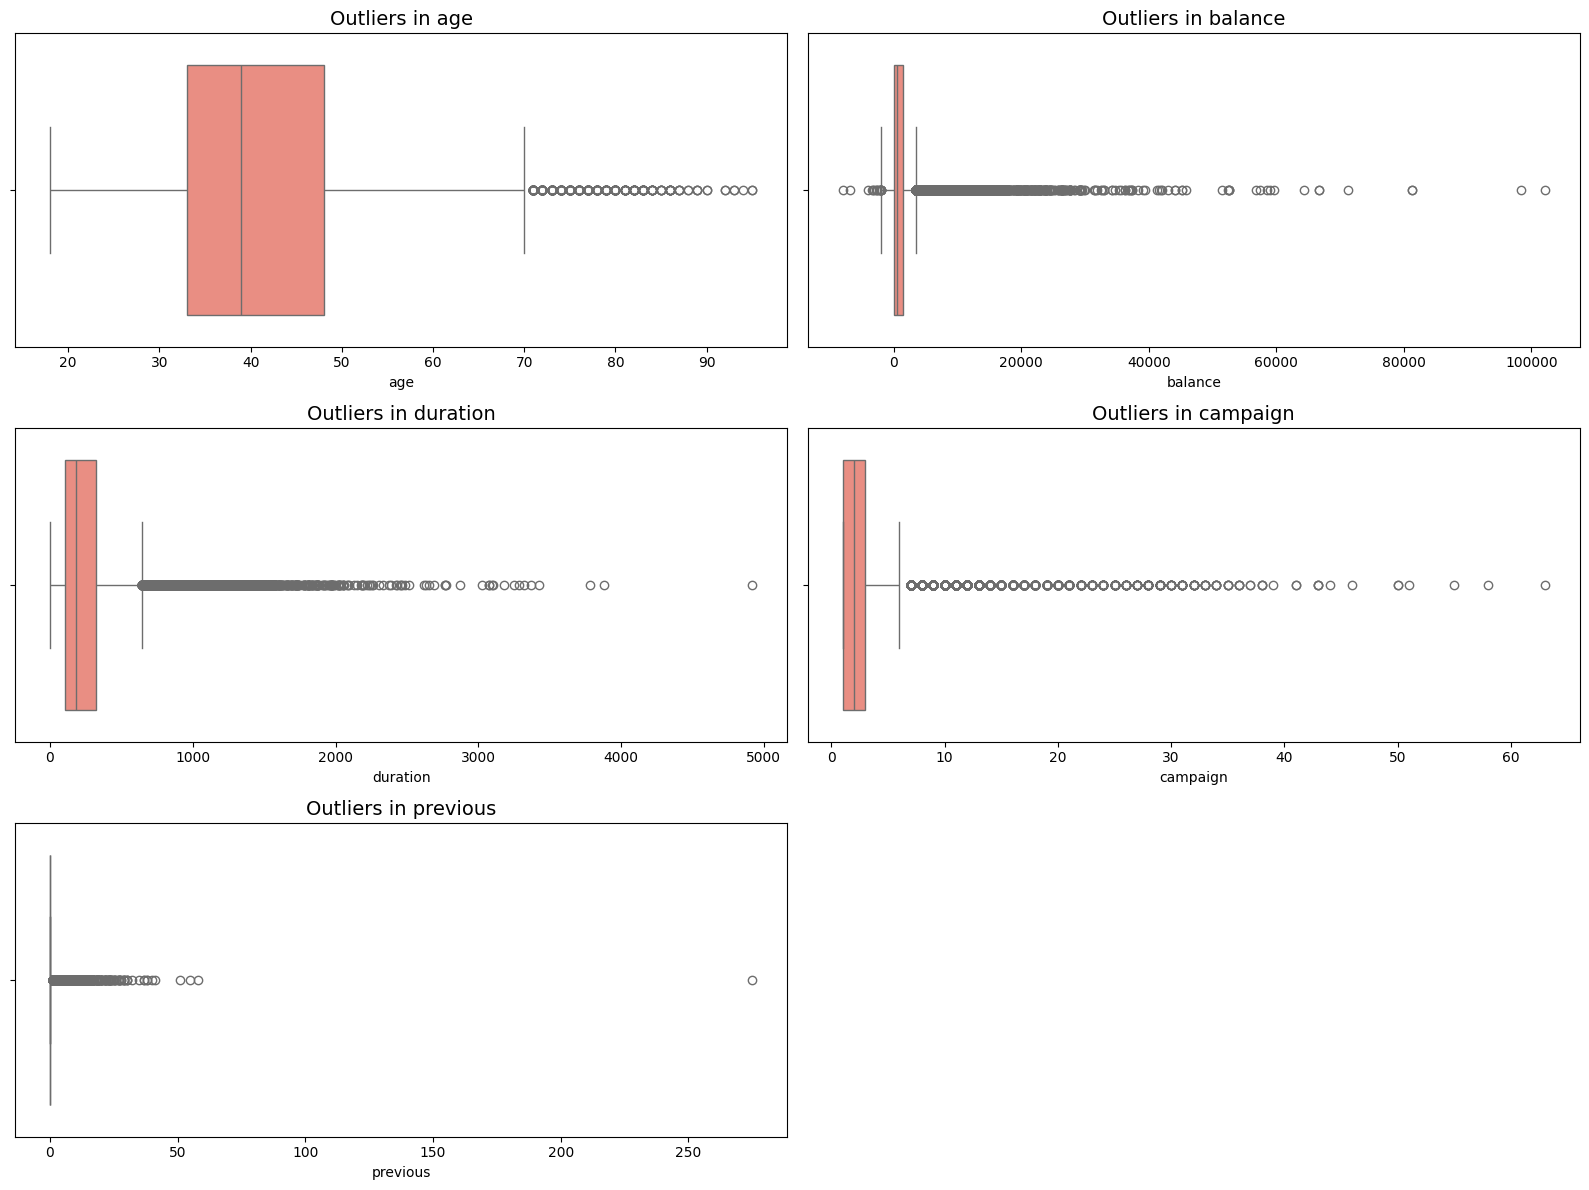

In [8]:
# List of numerical columns that likely have outliers
outlier_cols = ['age', 'balance', 'duration', 'campaign', 'previous']

plt.figure(figsize=(16, 12))

for i, col in enumerate(outlier_cols):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f'Outliers in {col}', fontsize=14)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

Using Boxplots is the industrial standard for identifying outliers because they visually represent the "Interquartile Range" (IQR). In banking data, outliers in balance or duration aren't always errors—they are often "High Net Worth" individuals or "Highly Engaged" prospects.

When we get to Cleaning, will not delete the outliers otherwise may lose too much data. Instead, will cap them at the 99th percentile. This keeps the "High Value" signal without letting the €102,127 balance break our model.

**Numerical Univariate Analysis**  (Use Histograms & Boxplots)

For these columns, we are looking for skewness (is the data centered?) and outliers (like your €102k balance).
Key Columns: age, balance, duration, campaign, pdays.

Visualizations to use:

Histograms: To see the distribution.

Boxplots: Specifically to identify those outliers you mentioned in your describe() output.

- age: To see the age range of the bank's customers.
- balance: To identify wealth distribution and extreme outliers (like the €102k you found).
- day: To see if calls are concentrated at the start, middle, or end of the month.
- duration: Crucial variable. High duration usually correlates with success.
- campaign: To see how many times a customer is usually contacted in one campaign.
- pdays: Note: $-1$ means "never contacted before." w'll see a huge spike at $-1$.
- previous: To see the history of previous contacts.

Check the "natural shape" of your continuous data.

Age: Is the bank targeting retirees or young professionals?

Balance: Is most of the data near zero? (In banking, this usually shows a "long tail" distribution).

Duration: Check for 0-second calls. These are "errors" (missed calls) that you'll want to clean later.

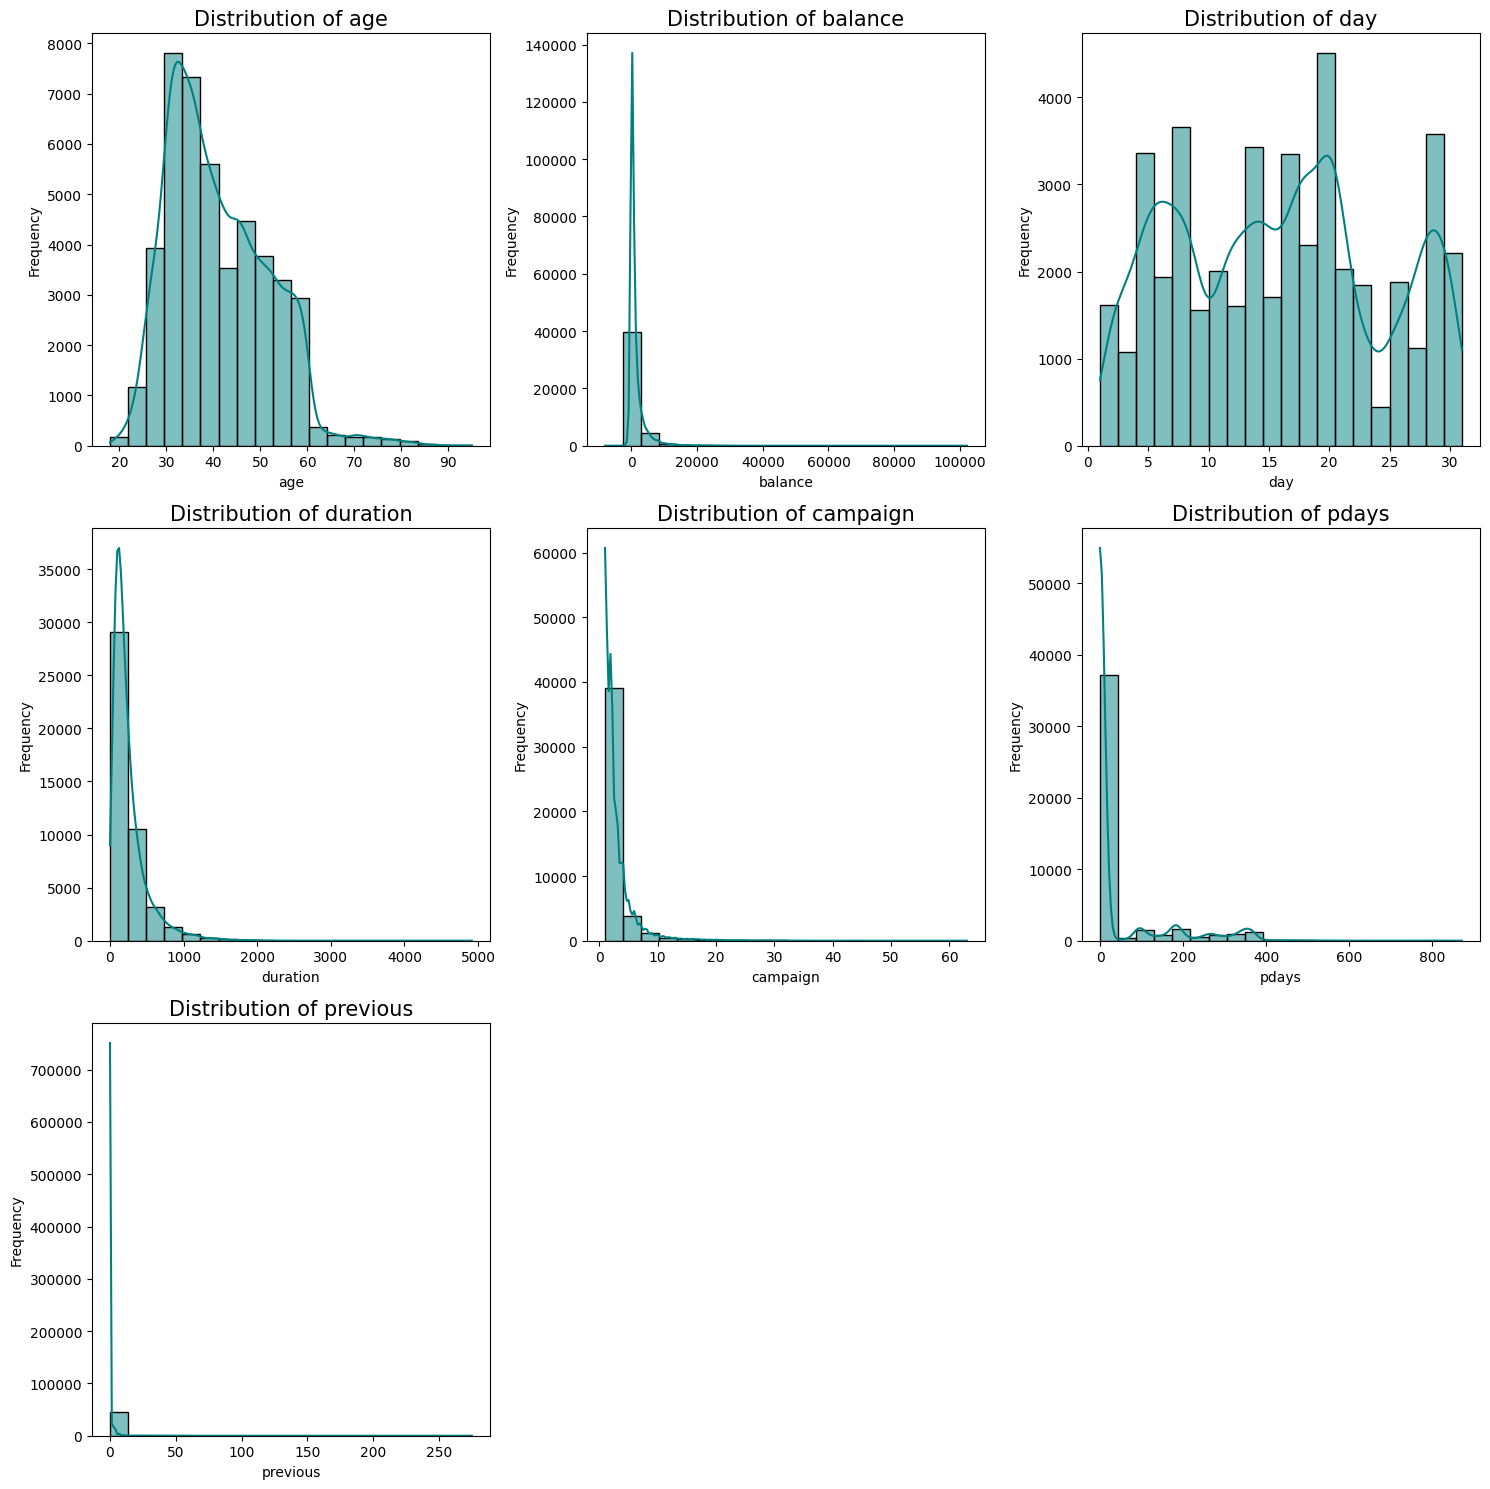

In [9]:
# EDA - Part A: Univariate Analysis (Numerical Variables)

# List of numerical columns
num_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Create subplots - 4 rows, 2 columns to fit all 7 variables
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten() # Flatten to 1D array for easy indexing

for i, col in enumerate(num_columns):
    sns.histplot(df[col], bins=20, kde=True, ax=axes[i], color='teal')
    axes[i].set_title(f'Distribution of {col}', fontsize=15)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove the 8th empty subplot (since we only have 7 numerical columns)
fig.delaxes(axes[7])
fig.delaxes(axes[8])

plt.tight_layout()
plt.show()

What to look for in these plots before deep cleaning:

age: Usually fairly normal but slightly right-skewed. that shows most customers are between 30 and 50.

balance: This will likely look like a single vertical line at the left because of those extreme outliers (€100k+). This is visual "proof" that says, need to cap or scale this data later.

duration: Heavily right-skewed. Most calls are short, but a few are very long. This is a very important predictor.

campaign: Most values are at the very low end (1-3 contacts). The "long tail" shows people contacted 60+ times—often considered outliers.

pdays: A massive spike at -1. This represents all the customers who were never contacted before. In banking, this is a distinct "New Lead" segment.

previous: Like campaign, mostly zeros. Any high numbers here are "Frequent Contacts."

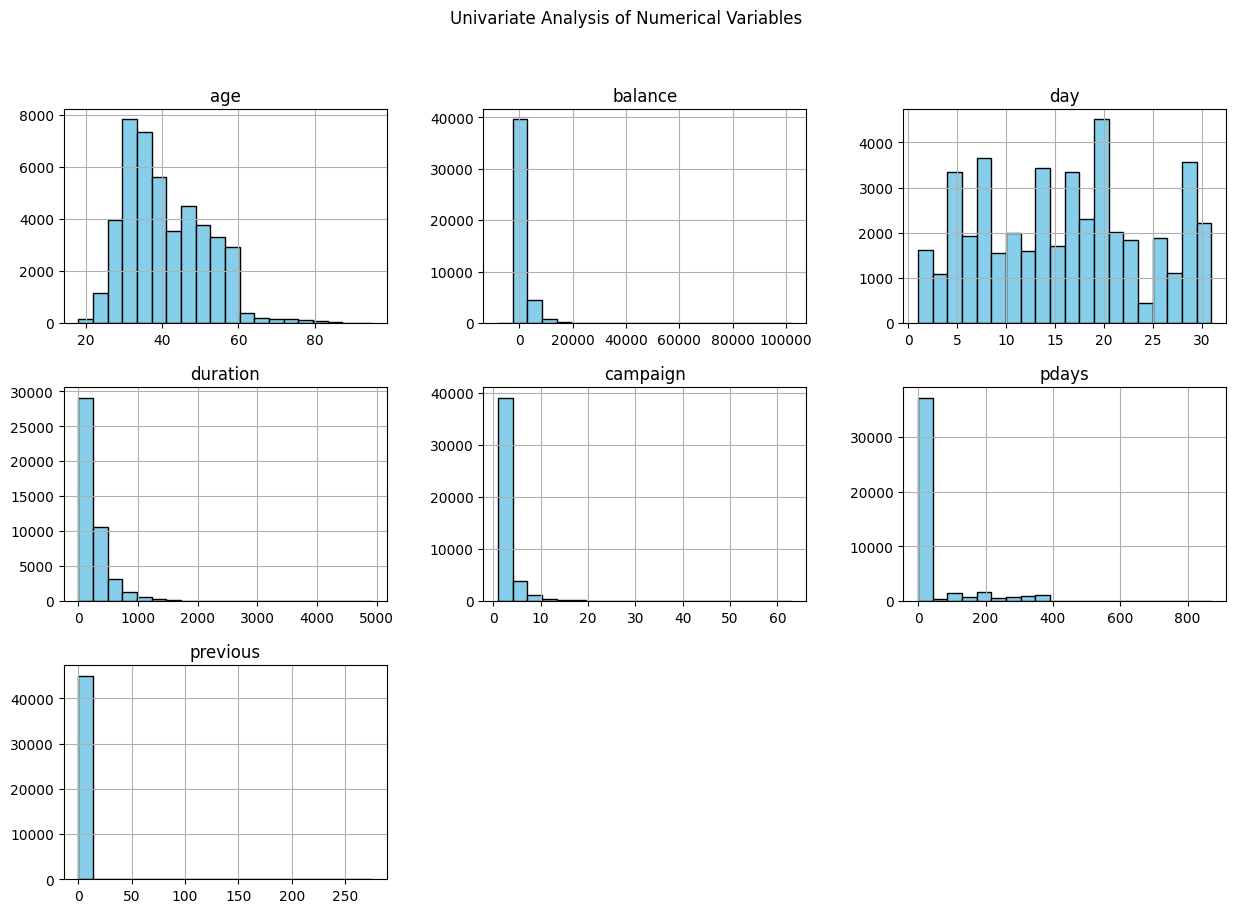

In [10]:
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
df[numerical_cols].hist(bins=20, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Univariate Analysis of Numerical Variables')
plt.show()

**Categorical Univariate Analysis**

For these, we are looking for frequency and imbalance. Want to see if one category dominates the others.

Key Columns: job, marital, education, default, housing, loan, contact, month, poutcome.

Visualizations to use:

Count Plots (Bar Charts): To see the frequency of each category.

What to look for: Does blue-collar make up 50% of the jobs? Is poutcome mostly "unknown"? (Which you already found is 81.75%!).

- job: Which professions does the bank target most?
- marital: Married, single, or divorced distribution.
- education: Educational background of the leads.
- default: Do many customers have credit in default? (Usually, most are "no").
- housing: How many have housing loans?
- loan: How many have personal loans?
- contact: How the bank reached out (Cellular vs. Telephone).
- month: Which months are the busiest for the bank?
- poutcome: Success/Failure of previous campaigns (Remember, this had 81% "unknown")

Look for "Sparse Classes" (categories with very few people).

Job: If "Student" or "Housemaid" only has a few rows, your model might struggle to learn about them.

Default: Does anyone actually have a credit default? If 99% are "No," this column might not be useful for the model.

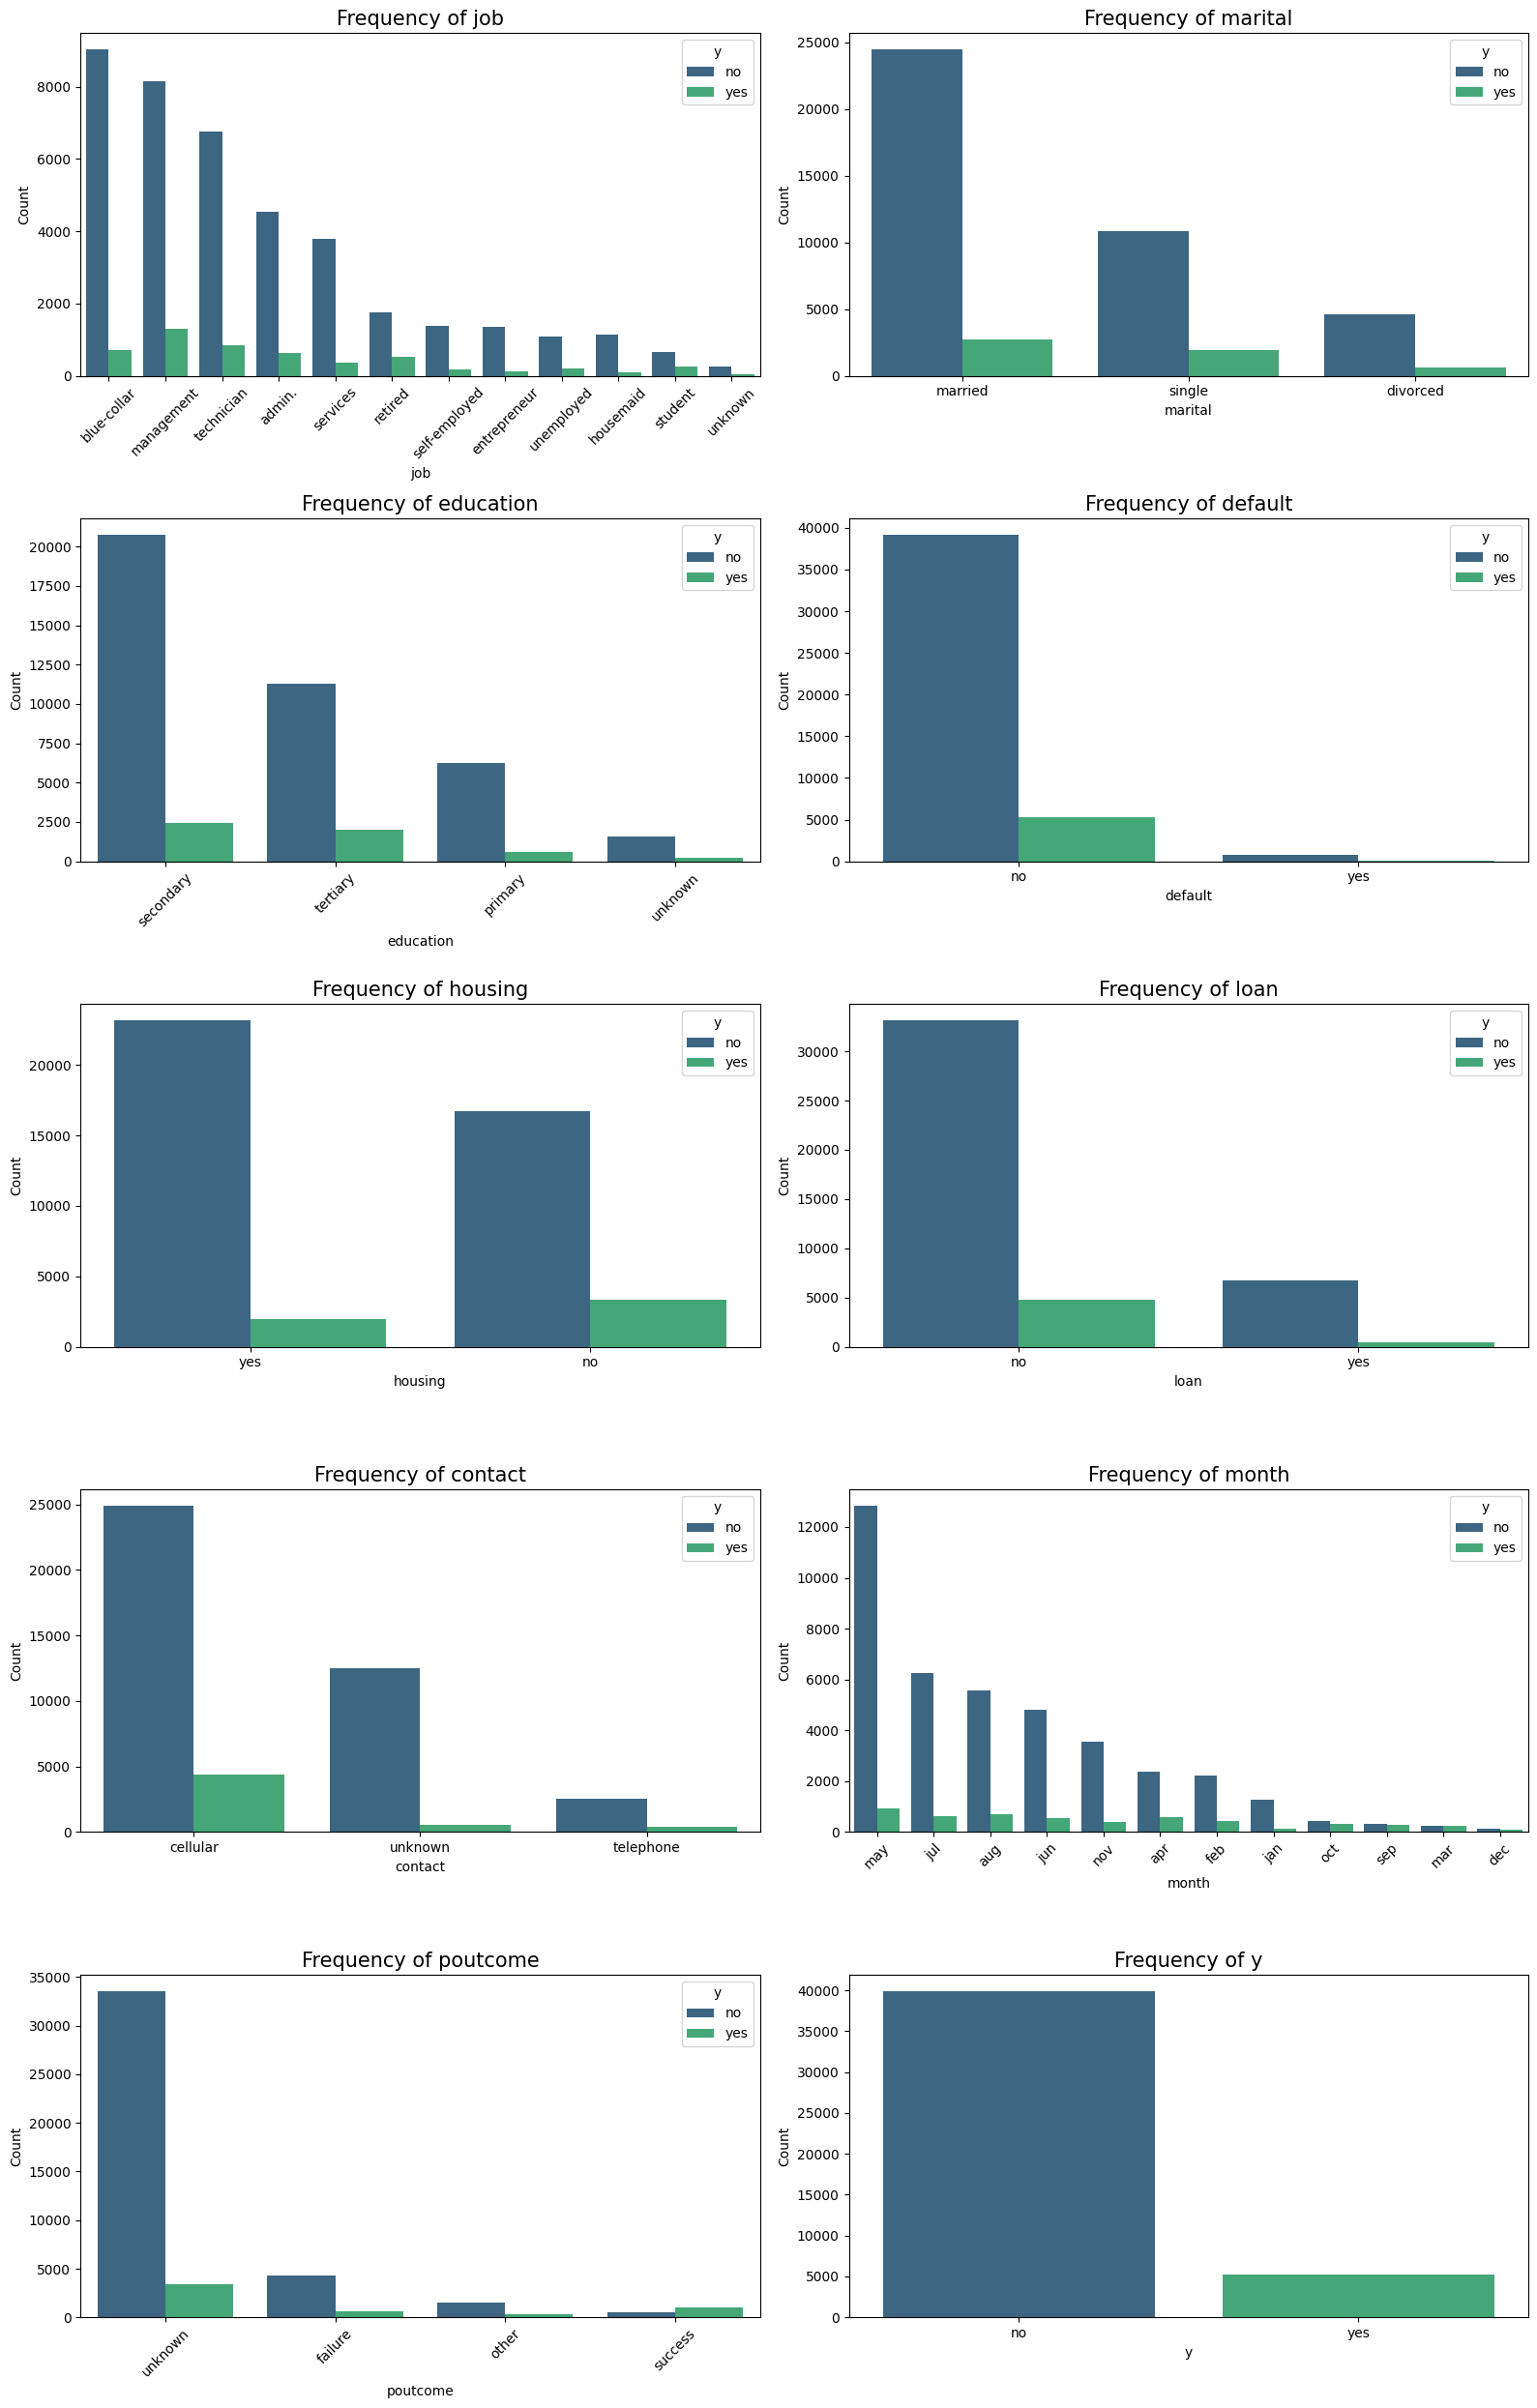

In [ ]:
# EDA - Part A: Univariate Analysis (Categorical Variables)
# Here is the code to generate subplots for all categorical variables. In the banking industry, it is called "Class Distribution Analysis"
# it's how one can spot the "Unknowns" and the class imbalance found in statistics.

# List of categorical columns from your info() output
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

# Create subplots - 5 rows, 2 columns for the 10 categorical variables
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 25))
axes = axes.flatten() # Flatten to 1D array for easy indexing

for i, col in enumerate(cat_columns):
    # Sort bars by frequency for better readability
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, hue='y', ax=axes[i], order=order, palette='viridis')
    
    axes[i].set_title(f'Frequency of {col}', fontsize=15)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    
    # Rotate x-labels for columns with many categories (like job and month)
    if df[col].nunique() > 3:
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Crucial Banking Insights to Spot:
Class Imbalance (The y chart):  we can see "no" towers over "yes." In a banking marketing context, this is normal but dangerous for a model. It means the model will naturally try to ignore the "yes" customers.

The "Unknown" Dominance: Look at poutcome. "unknown" is the massive majority. This visually confirms calculation that 81% of previous outcomes are missing.

Dominant Segments: Notice how blue-collar and management jobs, and married status, make up the bulk of our leads.

Credit Health: The default chart will likely be almost entirely "no." This tells that "default" might not have enough variance to be a strong predictor for model later.

Why we do this before deep cleaning:
By plotting these now, we can see the "unknown" bars. When we run our cleaning code later and re-plot these, those "unknown" bars will disappear (merged into the mode), and we can visually verify that your cleaning worked.

**The Target Variable (The Most Important One)**

Even though y is categorical, we analyze it alone first to check for Class Imbalance.

Column: y (Term Deposit Subscription).



y: This is the most important univariate analysis. We check for Class Imbalance. If 90% are "no" and 10% are "yes," we need to note this as it affects our future model's accuracy.



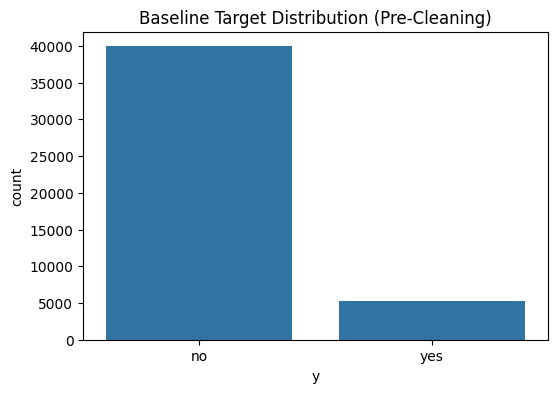

In [12]:
# 1. Visualize the Target (Check for Imbalance)
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=df) #, palette='viridis')
plt.title('Baseline Target Distribution (Pre-Cleaning)')
plt.show()

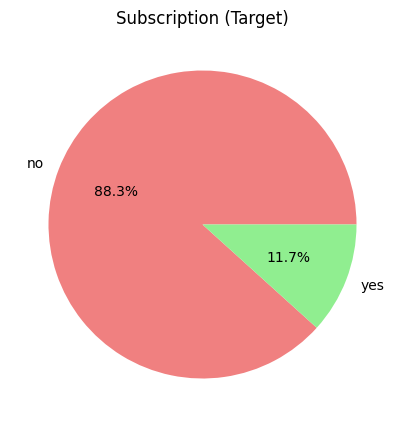

In [13]:
plt.figure(figsize=(5, 5)) #plt.subplot(1, 3, 3)
df['y'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('Subscription (Target)')
plt.show()

Insight: In this dataset, "no" usually happens about 88% of the time. This tells you that later on, you might need special modeling techniques (like SMOTE or class weights) because the "yes" cases are rare. 

Check the distribution of y.

Class Imbalance: In this dataset,  ~88% said "No" and ~12% said "Yes."

The Cleaning Impact: By looking at this now, we know that if we delete too many "unknown" rows later, we might accidentally delete all our "Yes" cases!

### featurization should be done before splitting or after splitting 

In the data science industry, the answer depends on what kind of featurization you are doing. Featurization is generally split into two categories: Structural and Statistical.

The industrial standard is to perform Structural featurization before the split and Statistical featurization after the split.

1. Structural Featurization (Before the Split)
    These are transformations based on logic, business rules, or domain knowledge. They do not depend on the distribution (mean, max, etc.) of the data.

    Examples: * Date Extraction: Turning a timestamp into "Day of Week" or "Month."

    Logic-Based Grouping: Creating an is_retired column if age > 65.

    Text Standardizing: Converting "Job" titles to lowercase.

    SQL Joins: Bringing in external data based on a Customer ID.

    Why: These rules are universal. A customer older than 65 is "Retired" regardless of who else is in the dataset. Doing this before the split keeps your pipeline simple.

2. Statistical Featurization (After the Split)
    These are transformations that are calculated based on the values of other rows in the dataset.

    Examples:

    Target Encoding: Replacing a category with the mean of the target variable.

    Standardization/Scaling: (x - mean) / std.

    Discretization/Binning: Creating "High/Medium/Low" bins based on quantiles.

    Handling Missing Values: Filling nulls with the mean or median.

    Why: If you calculate the "Average Balance" using the whole dataset and then split, your training set has "leaked" information about the average of the test set. This leads to Data Leakage, making your model look better on paper than it actually is.

The Industrial "Fit-Transform" Rule
The standard way to handle featurization that involves statistics is the Fit-Transform pattern:

Split the data into Train and Test.

Fit the featurizer (e.g., a Scaler or Target Encoder) on the Training Set only. (This calculates the mean/logic).

Transform both the Training Set and the Test Set using those saved parameters.

By focusing on these four, we are targeting the most "informative" dimensions of the banking data without cluttering the model.

Here is the professional implementation code for these specific features. You should run this after your cleaning (lowercase/strip/de-dupe) but before your Train-Test Split.

Why these 4 are "Safe" and "Smart":

Logic over Noise: By creating is_new_customer, you help the model understand that the value -1 in pdays isn't a small number—it's a completely different category of customer.

Compression: total_contacts summarizes the bank's relationship history into a single number, which is easier for a model to weigh than two separate counters.

Non-Linearity: call_efficiency captures a ratio. Standard linear models (like Logistic Regression) struggle to "see" ratios on their own; by calculating it for the model, you've made it much smarter.

In [14]:
# --- Feature Engineering: High-Value "Signals" ---

# 1. Contact Intensity (The 'Pressure' Signal)
# Combines current and past campaign contacts
df['total_contacts'] = df['campaign'] + df['previous']

# 2. Call Efficiency (The 'Interest' Signal)
# Seconds spent on the phone per contact attempt
# We add 1 to campaign to avoid division by zero
df['call_efficiency'] = df['duration'] / (df['campaign'] + 1)

# 3. Financial Stress Flag (The 'Capacity' Signal)
# Captures if a customer is burdened by multiple loan types
df['multiple_loans'] = ((df['housing'] == 'yes') & (df['loan'] == 'yes')).astype(int)

# 4. New Lead Discovery (The 'Relationship' Signal)
# Distinctly identifies customers who have never been called before (pdays = -1)
df['is_new_customer'] = (df['pdays'] == -1).astype(int)

print(f"Engineered Features Added. New shape: {df.shape}")

Engineered Features Added. New shape: (45211, 21)


In [16]:
# Save to processed directory
df.to_csv('../data/processed/df_processed.csv', index=False)

print("Data cleaning and feature engineering complete. Files saved to data/processed/.")


Data cleaning and feature engineering complete. Files saved to data/processed/.


Final Checklist Before the Split:
[x] Univariate EDA (Done)

[x] Basic Cleaning (De-dupe, Formatting, Strip/Lower)

[x] Structural Feature Engineering (The 4 features above)

[ ] Handle Outliers (Capping/Winsorization — Optional, but recommended before split if you want stable EDA plots)

[ ] Train-Test Split (The Firewall)

---------------------------------------------------------**Just for knowledge**--------------------------------------------------------

**QUE: We have 17 variables and adding these features will add more variables, is it good for model?**

That is a sensitive point and shows that one is thinking about the "Curse of Dimensionality." In data science, more is not always better, but in this specific case, adding these features is highly beneficial if done correctly.

Here is the industrial perspective on why we add variables and how to manage them:

1. Quality over Quantity (Feature Signal)
Models like Logistic Regression or Decision Trees are only as smart as the data we give them.

Raw Variable: age (A number from 18-95). The model has to figure out the patterns itself.

Engineered Variable: is_retired (0 or 1). You have just "handed" the model a powerful signal that retirees behave differently.
Industrial Rule: It is better to have 25 variables with 5 "strong signals" than 17 variables with only "weak signals."

2. The "Curse of Dimensionality"
You are right to be cautious. If you add 100s of variables to a small dataset, the model might "overfit" (memorize noise). However, for your dataset (45,211 rows), moving from 17 to 25 or 30 variables is perfectly safe. You have enough "observations" to support that many features.

3. How to handle "Too Many Variables"
In a professional workflow, we don't just keep every feature we create. We use a Feature Selection process:

Create everything: Add your SQL-inspired and structural features.

Check Correlation: Use a Heatmap. If two features are 95% identical (like pdays and is_new_customer), you drop one.

Check Importance: After training, look at "Feature Importance." If a feature you created has 0% impact, you remove it in the next iteration.

4. Which to keep? (The Pareto Principle)
Focus on adding features that represent Interaction or Non-Linearity.

Good: call_efficiency (It combines two variables into one meaningful ratio).

Good: is_new_customer (It solves the problem of the -1 in pdays which confuses models).